So the motivation for this was, to be entirely honest, kind of selfish. I'm buying a house and I want to see how much my house *could* increase by in 'N' years. Basically, a kind of experiment. It is also handy for me to practice time-series analysis, bit of data science stuff, and some ML practice.

The project is broken down into a few parts:
1. the web-scraping, to gather data from the [RightMove.co.uk](https://www.rightmove.co.uk) website. For historical data, and then use this to try and predict how the houses will increase.
2. the analysis of the data, see if there any trends I can see from this analysis as is.
3. the forecasting, can I do some basic forecasting with the data alone, or can I set up an ML model to predict it for me.

# 1. Importing and Pre-Processing
## 1.1 Imports and Load Data

In [97]:

random_code = 42  # Random code to use and replicate results for each run.
train_frac = 0.8
year_max = 2050

# File imports 
import os

# Data Imports
# - Dataframe 
import numpy as np
import pandas as pd
# - Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
# - Machine Learning
# - - Classical 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# - - Neural Networks
import torch
import torch.nn as nn
import torch.optim as optim
# - Stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# - Oversampling
import smogn

# Geography imports
import plotly.express as px
        
# Personal Import
from Dataset_Snapshot import RightMoveScraper

Run the next function as needed if you need a new CSV to work with. This will generate a CSV for every run of this code, this is not ideal. Plus also as a basic tool, a separate python file will suffice.

In [2]:
"""# Create an instance of the scraper
scraper = RightMoveScraper(num_pages=10)  # Adjust the number of pages as needed
scraper.run()"""

'# Create an instance of the scraper\nscraper = RightMoveScraper(num_pages=10)  # Adjust the number of pages as needed\nscraper.run()'

In [3]:
data_file = 'rightmove_housing_data_20250330_233719.csv'
df = pd.read_csv(data_file)

## 1.2 Data Clean Up
Tidy up the data now as it's not really in a state to use just yet.

In [4]:
print(df.dtypes)  # Look at the types of each column

address           object
propertyType      object
bedrooms         float64
bathrooms        float64
latitude         float64
longitude        float64
display_price     object
date_sold         object
dtype: object


In [5]:
# Display Price Changes - change from 'str' to 'float'
df['display_price'] = df['display_price'].replace('[^0-9.]', '', regex=True).astype(float) 
# Date Sold changes - change from DD-MM-YYYY 'str' to YYYYMMDD 'int'
df['date_sold'] = pd.to_datetime(df['date_sold'], errors='coerce')
df['date_sold'] = df['date_sold'].dt.strftime('%Y%m%d').astype(int)
print(df.dtypes)  # Look 

address           object
propertyType      object
bedrooms         float64
bathrooms        float64
latitude         float64
longitude        float64
display_price    float64
date_sold          int32
dtype: object


In [6]:
df.head()

,address,propertyType,bedrooms,bathrooms,latitude,longitude,display_price,date_sold
0,"9, Stallcourt Avenue, Cardiff CF23 5AL",TERRACED,3.0,2.0,51.49517,-3.15421,437000.0,20250110
1,"9, Stallcourt Avenue, Cardiff CF23 5AL",TERRACED,3.0,2.0,51.49517,-3.15421,330000.0,20190418
2,"87, Clifton Street, Cardiff CF24 1LT",TERRACED,3.0,1.0,51.48374,-3.15580,240000.0,20250110
3,"87, Clifton Street, Cardiff CF24 1LT",TERRACED,3.0,1.0,51.48374,-3.15580,207000.0,20221028
4,"87, Clifton Street, Cardiff CF24 1LT",TERRACED,3.0,1.0,51.48374,-3.15580,151000.0,20150723


## 1.3 Basic Analysis

In [7]:

color_scale = [(0, 'yellow'), (1,'red')]
# Display the data on the map
map_fig = px.scatter_mapbox(df, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="address", 
                        hover_data=["address", "display_price", 'date_sold'],
                        color="display_price",
                        color_continuous_scale=color_scale,
                        size="display_price",
                        zoom=13, 
                        height=600,
                        width=1200)

map_fig.update_layout(mapbox_style="open-street-map")
map_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
map_fig.show()

map_fig.write_image("img//mapped_dataset.jpg")

Displaying a copy of the above two cells, as it doesn't show the interactive plotly fig in git.
![alt text](./img//mapped_dataset.jpg "Title")

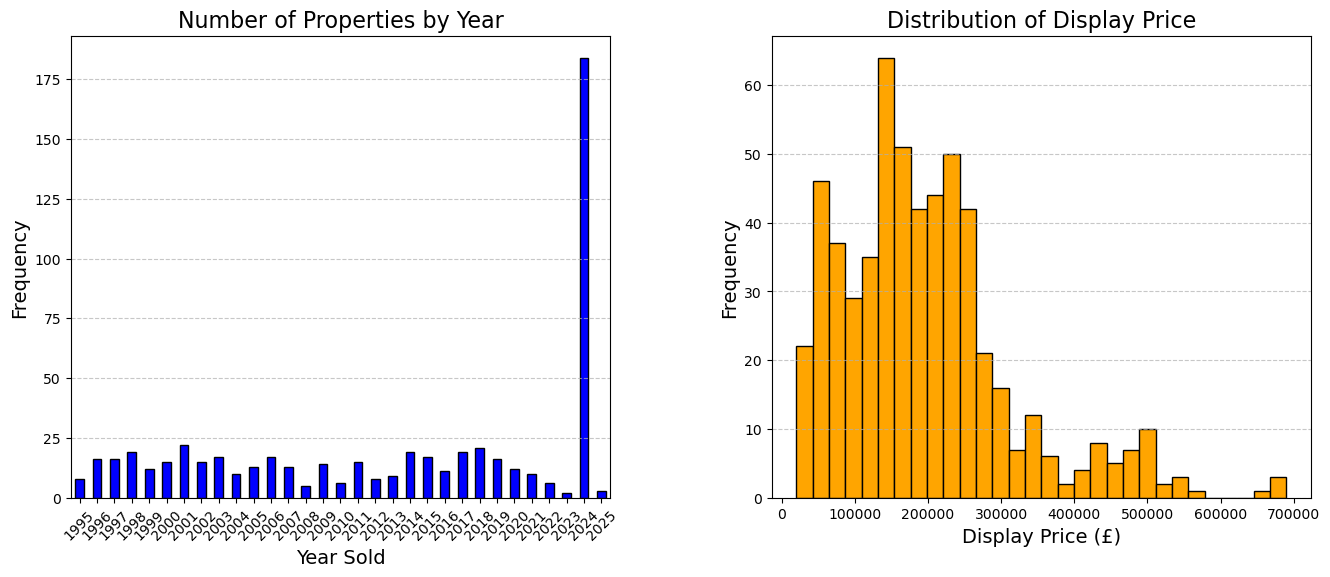

In [8]:
# Extract the year from the 'date_sold' column
df['year_sold'] = pd.to_datetime(df['date_sold'], format='%Y%m%d', errors='coerce').dt.year

fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'wspace': 0.3})

# First subplot: Number of properties by year
df['year_sold'].value_counts().sort_index().plot(kind='bar', edgecolor='black', ax=axes[0], color='blue')
axes[0].set_title('Number of Properties by Year', fontsize=16)
axes[0].set_xlabel('Year Sold', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Second subplot: Histogram of display_price
axes[1].hist(df['display_price'], bins=30, color='orange', edgecolor='black')
axes[1].set_title('Distribution of Display Price', fontsize=16)
axes[1].set_xlabel('Display Price (£)', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

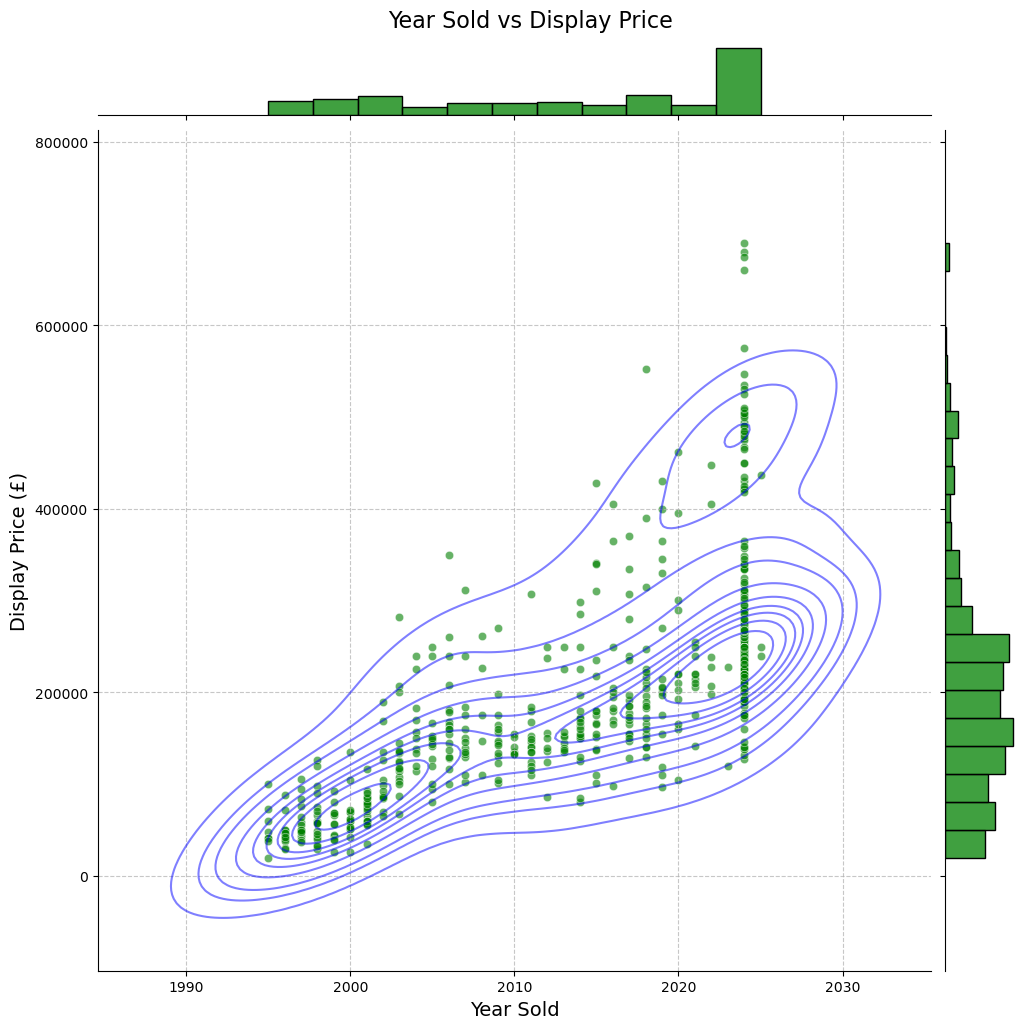

In [9]:
sns.jointplot(data=df,x='year_sold',y='display_price',kind='scatter',alpha=0.6,color='green',height=10, ratio=10) # Generate Scatter and hist
sns.kdeplot(data=df,x='year_sold',y='display_price',levels=10,color='blue',alpha=0.5,)  # KDE plot to generate contour map 

plt.suptitle('Year Sold vs Display Price', y=1.02, fontsize=16)
plt.xlabel('Year Sold', fontsize=14)
plt.ylabel('Display Price (£)', fontsize=14)

# Show the plot
plt.grid(linestyle='--', alpha=0.7)
plt.show()

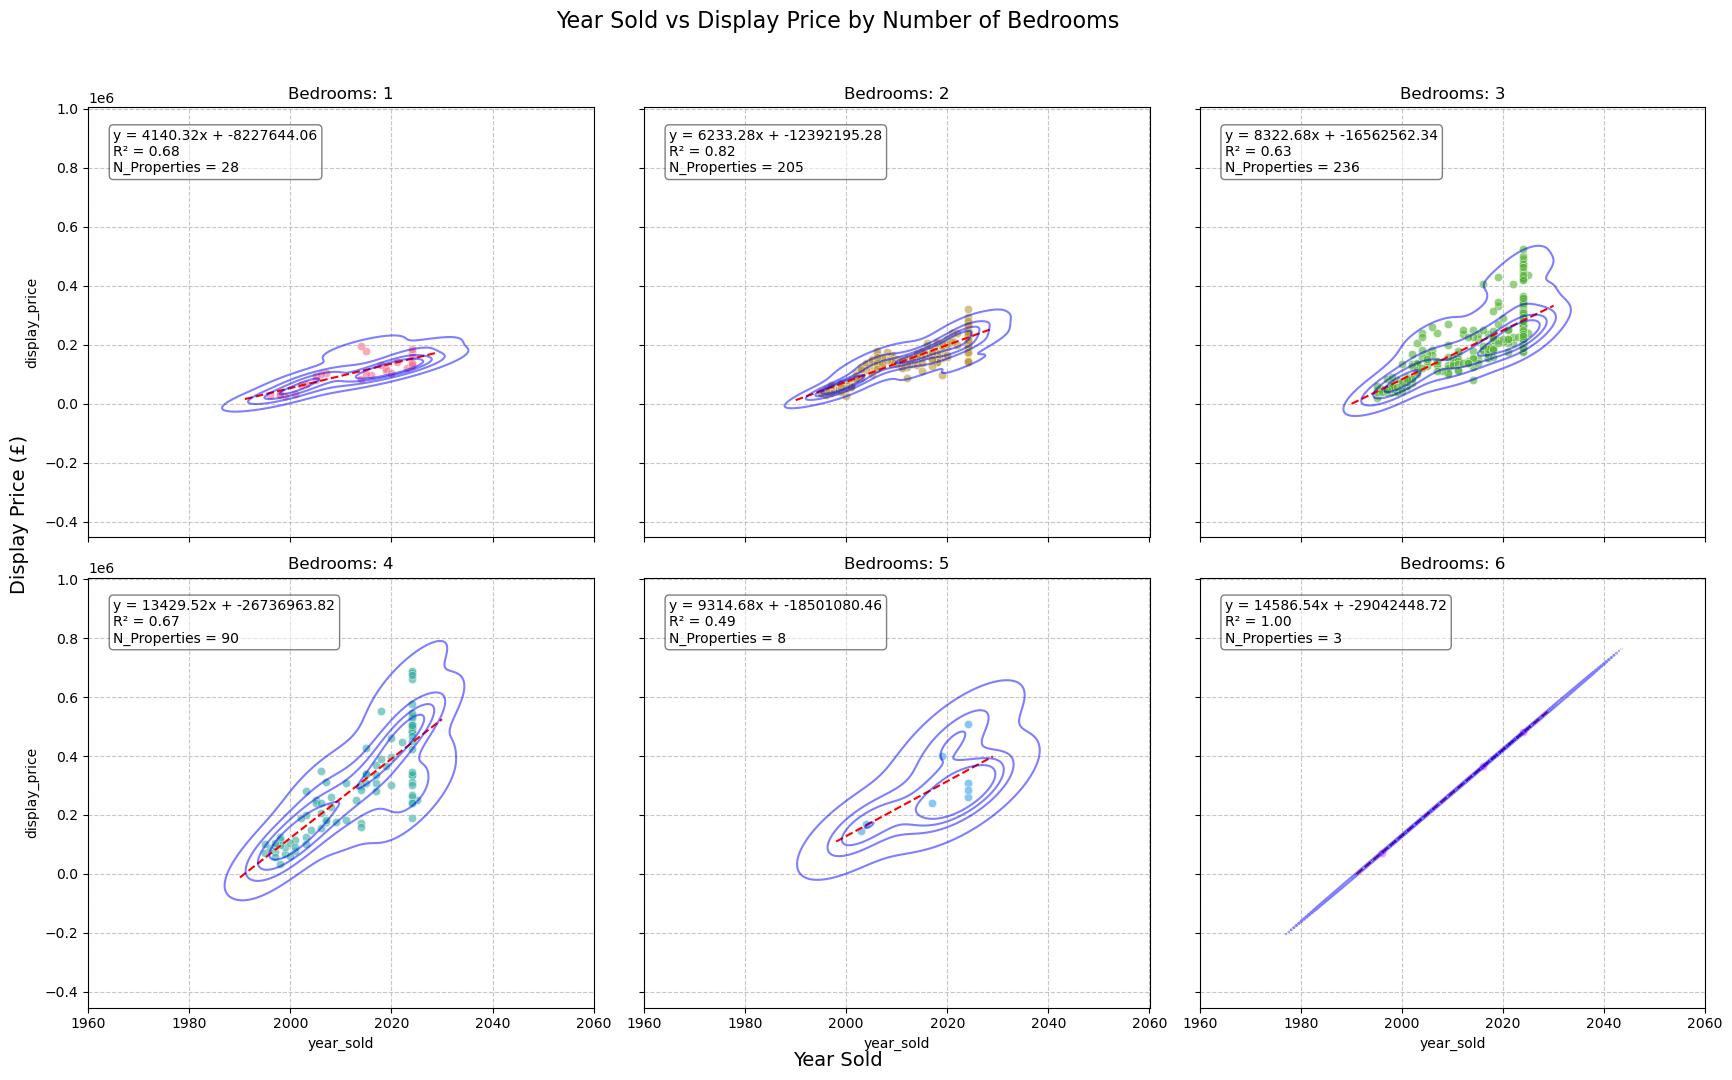

{1: {'m': array([4140.31697]), 'c': -8227644.064117551, 'r2': 0.6758838099252615, 'N': 28}, 2: {'m': array([6233.27889994]), 'c': -12392195.28039379, 'r2': 0.8217105756030633, 'N': 205}, 3: {'m': array([8322.67852082]), 'c': -16562562.344368327, 'r2': 0.6268213632262941, 'N': 236}, 4: {'m': array([13429.51925073]), 'c': -26736963.822666798, 'r2': 0.671956503006311, 'N': 90}, 5: {'m': array([9314.67523831]), 'c': -18501080.458878297, 'r2': 0.49042314792622743, 'N': 8}, 6: {'m': array([14586.53846154]), 'c': -29042448.717948724, 'r2': 0.999982473897695, 'N': 3}}


In [ ]:
unique_bedrooms = np.sort(df['bedrooms'].dropna().unique())
colors = sns.color_palette("husl", len(unique_bedrooms))

fig, axes = plt.subplots(nrows=int(np.ceil(len(unique_bedrooms) / 3)), ncols=3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

lin_reg = {}
# Loop through each unique number of bedrooms and plot
for i, bedrooms in enumerate(unique_bedrooms):
    ax = axes[i]
    subset = df[df['bedrooms'] == bedrooms]  # Filter data for the current number of bedrooms
    
    # Scatter plot
    sns.scatterplot(data=subset, x='year_sold', y='display_price', alpha=0.6, ax=ax, color=colors[i])
    
    # Fit linear regression
    if len(subset) > 1:  # Ensure there is enough data to fit a regression
        X = subset['year_sold'].values.reshape(-1, 1)
        y_vals = subset['display_price'].values
        reg = LinearRegression().fit(X, y_vals)
        # Extend regression line
        x_range = np.linspace(X.min() - 5, X.max() + 5, 100).reshape(-1, 1)
        y_range = reg.predict(x_range)
        ax.plot(x_range, y_range, color='red', linestyle='--', label='Regression Line')
        
        r2 = reg.score(X, y_vals)
        ax.text(0.05, 0.95, f"y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}\nR² = {r2:.2f}\nN_Properties = {len(subset)}",
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round", alpha=0.5, facecolor="white"))
        
        # Dictionary output
        lin_reg[int(bedrooms)] = {'m': reg.coef_, 'c': reg.intercept_, 'r2': r2, 'N':len(subset)}

    else:
        # Add number of data points if regression is not performed
        ax.text(0.05, 0.95, f"N = {len(subset)}",
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round", alpha=0.5, facecolor="white"))

    # KDE plot
    sns.kdeplot(data=subset, x='year_sold', y='display_price', levels=5, color='blue', alpha=0.5, ax=ax)
    
    ax.set_title(f"Bedrooms: {int(bedrooms)}")
    ax.grid(linestyle='--', alpha=0.7)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Year Sold vs Display Price by Number of Bedrooms", y=0.92, fontsize=16)
fig.text(0.5, 0.04, "Year Sold", ha="center", fontsize=14)
fig.text(0.04, 0.5, "Display Price (£)", va="center", rotation="vertical", fontsize=14)

# Show the plot
plt.tight_layout(rect=[0.04, 0.04, 1, 0.9])
plt.show()

print(lin_reg)

C:\Users\roryj\AppData\Local\Temp\ipykernel_26208\3428884656.py:47: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.



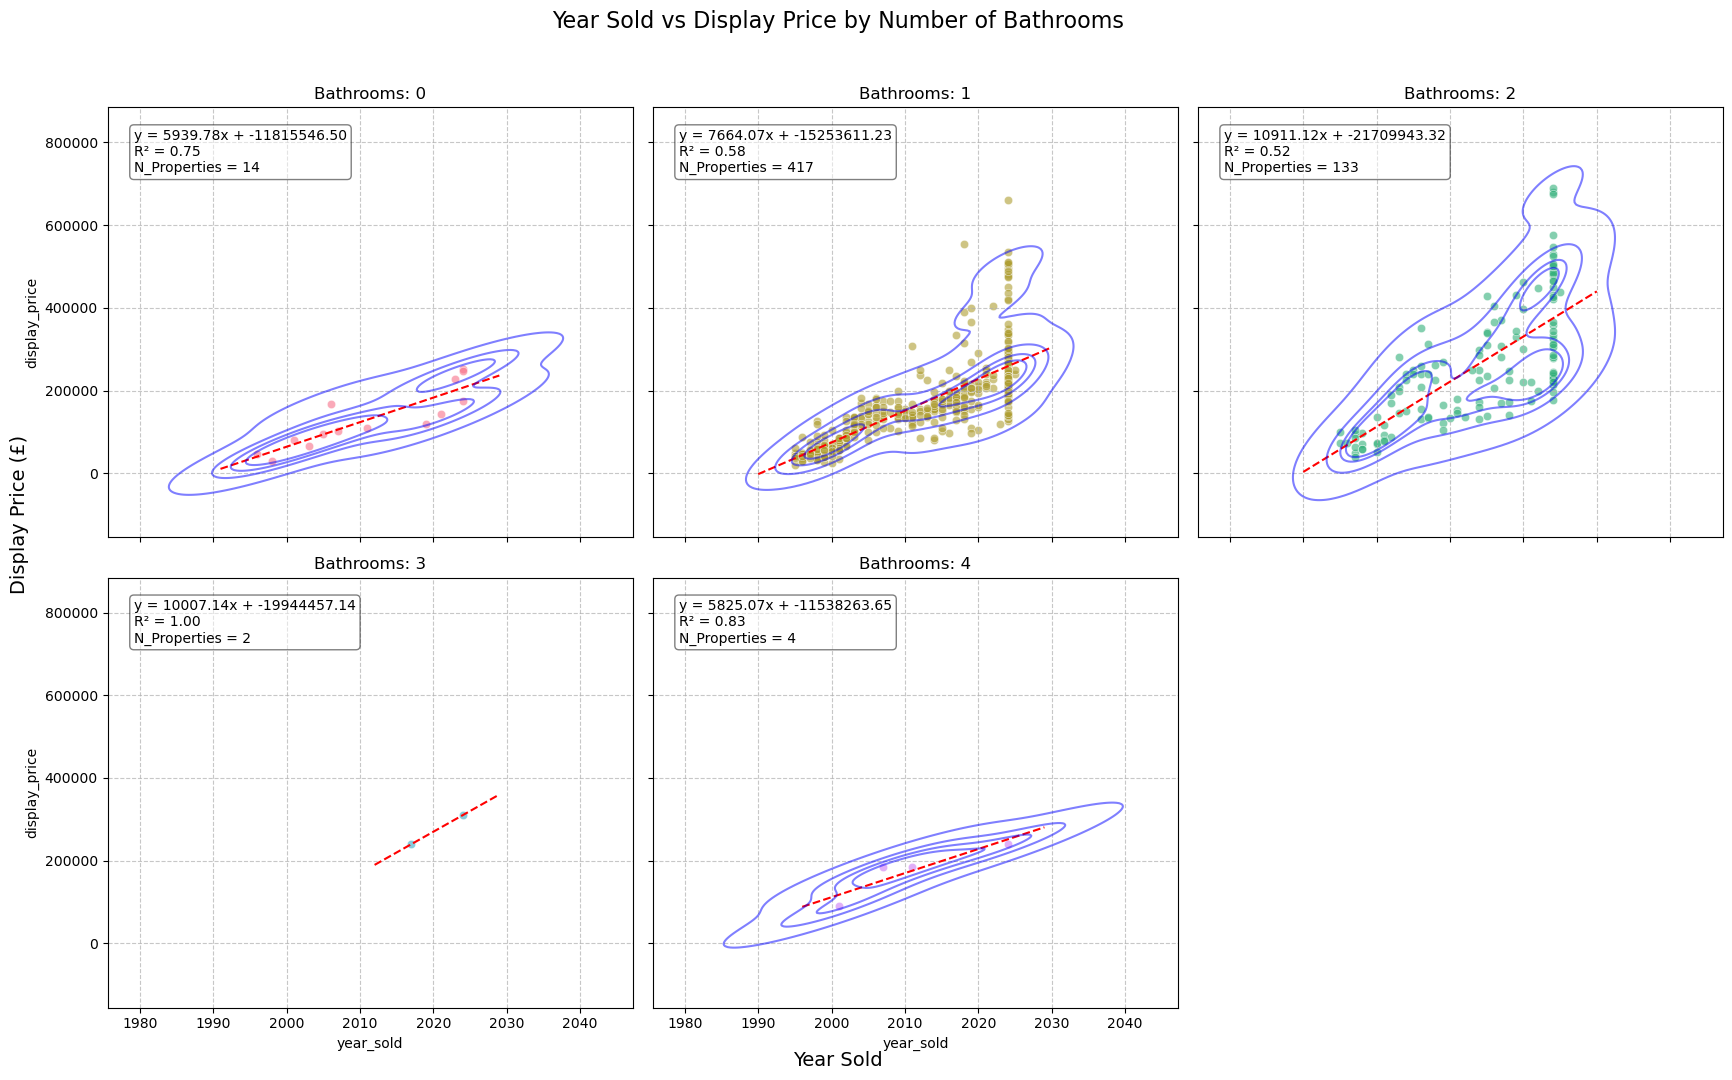

{0: {'m': array([5939.78058905]), 'c': -11815546.496343143, 'r2': 0.7512952232615716, 'N': 14}, 1: {'m': array([7664.06551032]), 'c': -15253611.229523059, 'r2': 0.583706116064294, 'N': 417}, 2: {'m': array([10911.12333399]), 'c': -21709943.31811182, 'r2': 0.5175839904482806, 'N': 133}, 3: {'m': array([10007.14285714]), 'c': -19944457.142857146, 'r2': 1.0, 'N': 2}, 4: {'m': array([5825.06584723]), 'c': -11538263.6523266, 'r2': 0.8322067818051467, 'N': 4}}


In [ ]:
unique_bathrooms = np.sort(df['bathrooms'].dropna().unique())
colors = sns.color_palette("husl", len(unique_bathrooms))

fig, axes = plt.subplots(nrows=int(np.ceil(len(unique_bathrooms) / 3)), ncols=3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

lin_reg_bathrooms = {}
# Loop through each unique number of bathrooms and plot
for i, bathrooms in enumerate(unique_bathrooms):
    ax = axes[i]
    subset = df[df['bathrooms'] == bathrooms]  # Filter data for the current number of bathrooms
    
    # Scatter plot
    sns.scatterplot(data=subset, x='year_sold', y='display_price', alpha=0.6, ax=ax, color=colors[i])
    
    # Fit linear regression
    if len(subset) > 1:  # Ensure there is enough data to fit a regression
        X = subset['year_sold'].values.reshape(-1, 1)
        y_vals = subset['display_price'].values
        reg = LinearRegression().fit(X, y_vals)
        # Extend regression line
        x_range = np.linspace(X.min() - 5, X.max() + 5, 100).reshape(-1, 1)
        y_range = reg.predict(x_range)
        ax.plot(x_range, y_range, color='red', linestyle='--', label='Regression Line')
        
        r2 = reg.score(X, y_vals)
        ax.text(0.05, 0.95, f"y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}\nR² = {r2:.2f}\nN_Properties = {len(subset)}",
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round", alpha=0.5, facecolor="white"))
        
        # Dictionary output
        lin_reg_bathrooms[int(bathrooms)] = {'m': reg.coef_, 'c': reg.intercept_, 'r2': r2, 'N':len(subset)}

    else:
        # Add number of data points if regression is not performed
        ax.text(0.05, 0.95, f"N = {len(subset)}",
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round", alpha=0.5, facecolor="white"))

    # KDE plot
    sns.kdeplot(data=subset, x='year_sold', y='display_price', levels=5, color='blue', alpha=0.5, ax=ax)
    
    ax.set_title(f"Bathrooms: {int(bathrooms)}")
    ax.grid(linestyle='--', alpha=0.7)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Year Sold vs Display Price by Number of Bathrooms", y=0.92, fontsize=16)
fig.text(0.5, 0.04, "Year Sold", ha="center", fontsize=14)
fig.text(0.04, 0.5, "Display Price (£)", va="center", rotation="vertical", fontsize=14)

# Show the plot
plt.tight_layout(rect=[0.04, 0.04, 1, 0.9])
plt.show()

print(lin_reg_bathrooms)

## 1.4 Linear Regression & Forecasting

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning:

divide by zero encountered in scalar divide



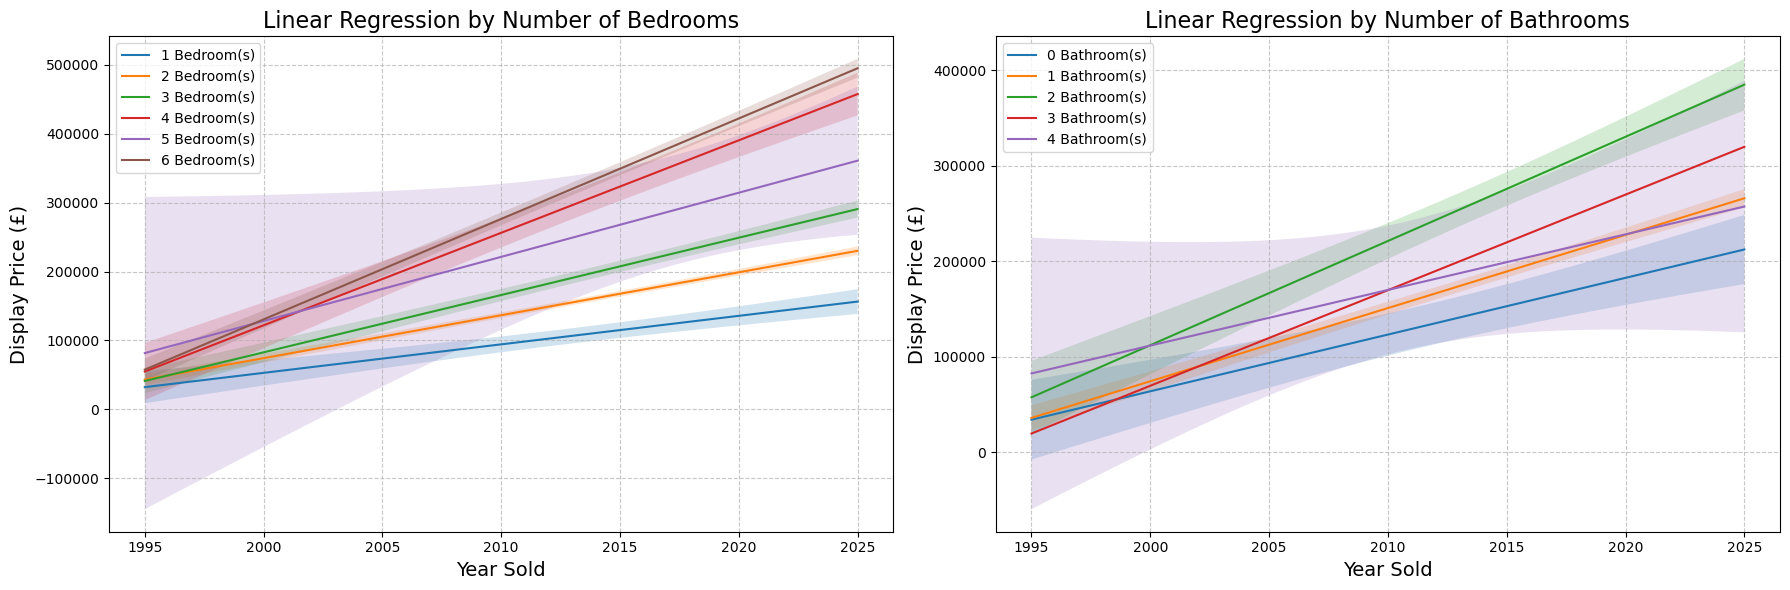

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))  # Create a 1x2 grid of subplots
x_range = np.linspace(df['year_sold'].min(), df['year_sold'].max(), 100)

# Plot 1: Linear regression by Number of Bedrooms
ax = axes[0]
for bedrooms in lin_reg.keys():
    # Filter data for the current number of bedrooms
    subset = df[df['bedrooms'] == bedrooms]
    
    # Fit the regression model using statsmodels
    X = sm.add_constant(subset['year_sold'])  # Add constant for the intercept
    y = subset['display_price']
    model = sm.OLS(y, X).fit()
    
    # Predict values and confidence intervals
    X_pred = sm.add_constant(x_range)  # Add constant to the x_range for predictions
    y_pred = model.predict(X_pred)  # Predicted values
    conf_int = model.get_prediction(X_pred).conf_int()  # Confidence intervals
    
    # Plot the regression line
    ax.plot(x_range, y_pred, label=f"{int(bedrooms)} Bedroom(s)")
    
    # Plot the confidence intervals as a shaded region
    ax.fill_between(x_range, conf_int[:, 0], conf_int[:, 1], alpha=0.2)

# Add labels, title, and legend
ax.set_title('Linear Regression by Number of Bedrooms', fontsize=16)
ax.set_xlabel('Year Sold', fontsize=14)
ax.set_ylabel('Display Price (£)', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(linestyle='--', alpha=0.7)

# Plot 2: Linear regression by Number of Bathrooms
ax = axes[1]
for bathrooms in sorted(df['bathrooms'].unique()):
    # Filter data for the current number of bathrooms
    subset = df[df['bathrooms'] == bathrooms]
    
    # Fit the regression model using statsmodels
    X = sm.add_constant(subset['year_sold'])  # Add constant for the intercept
    y = subset['display_price']
    model = sm.OLS(y, X).fit()
    
    # Predict values and confidence intervals
    X_pred = sm.add_constant(x_range)  # Add constant to the x_range for predictions
    y_pred = model.predict(X_pred)  # Predicted values
    conf_int = model.get_prediction(X_pred).conf_int()  # Confidence intervals
    
    # Plot the regression line
    ax.plot(x_range, y_pred, label=f"{int(bathrooms)} Bathroom(s)")
    
    # Plot the confidence intervals as a shaded region
    ax.fill_between(x_range, conf_int[:, 0], conf_int[:, 1], alpha=0.2)

ax.set_title('Linear Regression by Number of Bathrooms', fontsize=16)
ax.set_xlabel('Year Sold', fontsize=14)
ax.set_ylabel('Display Price (£)', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

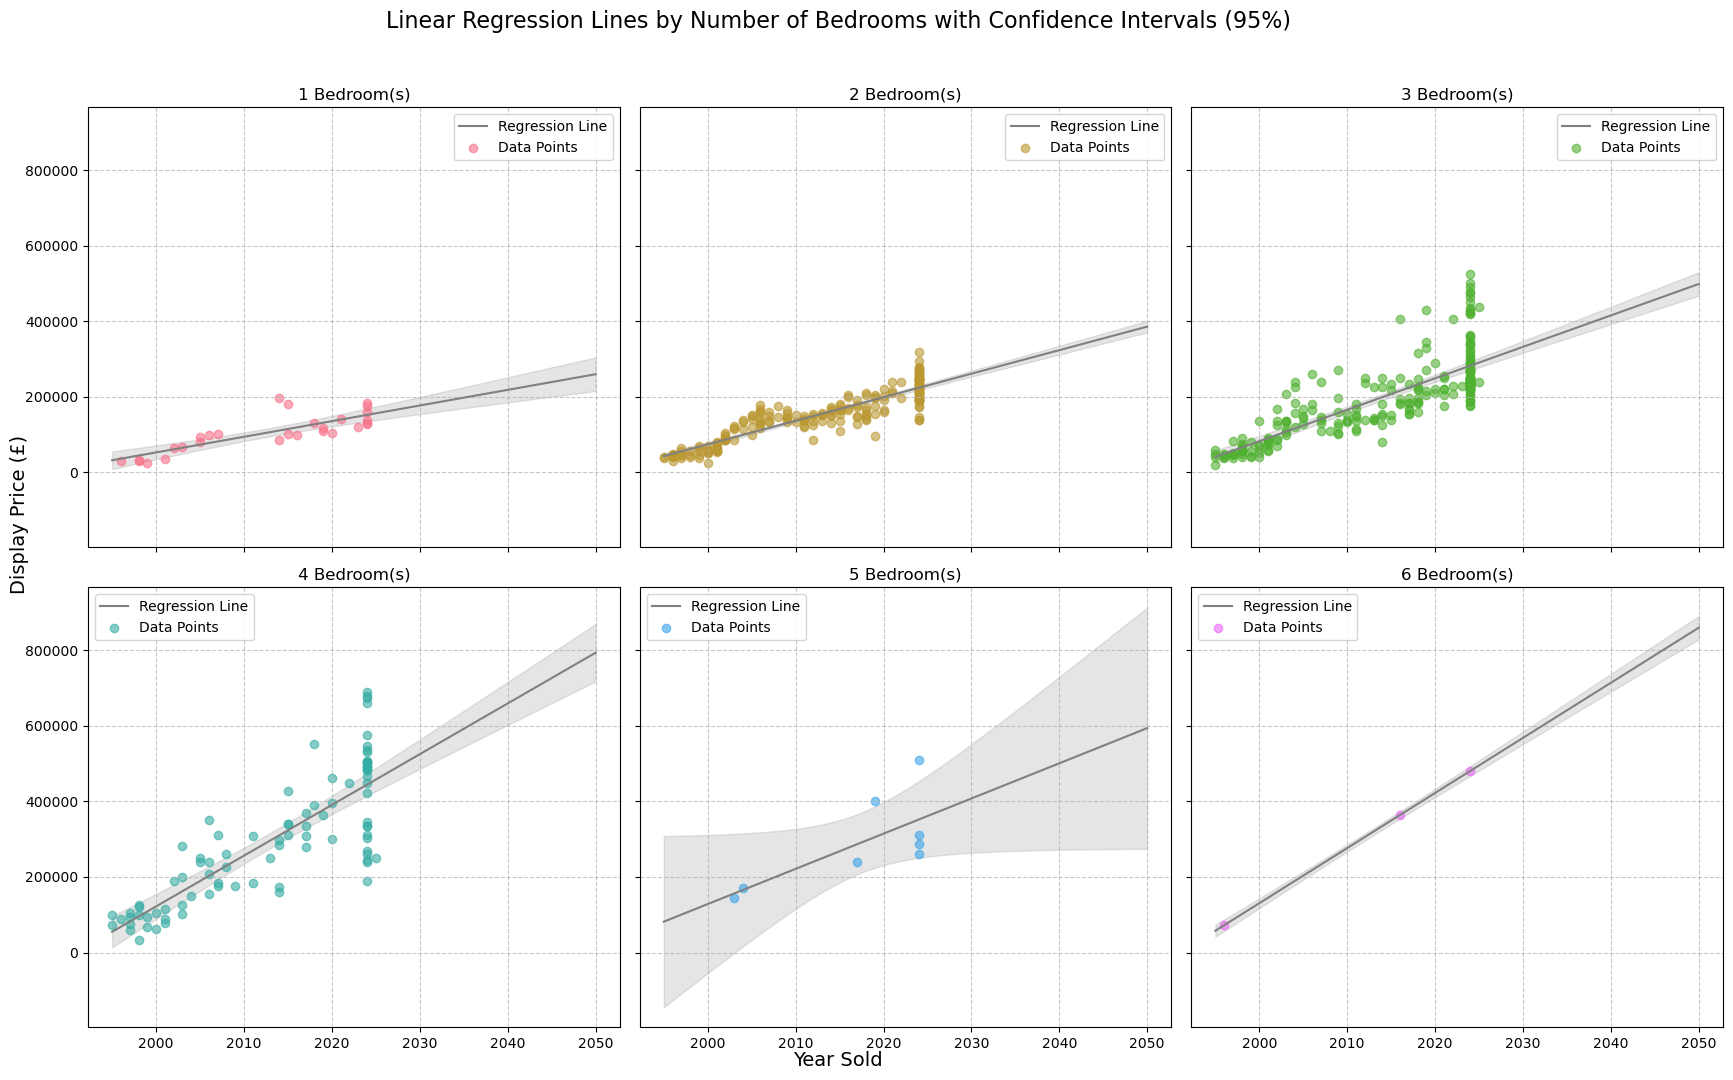

In [29]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(lin_reg.keys()) / 3)), ncols=3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

x_range = np.linspace(df['year_sold'].min(), 2050, 100)

# Loop through each bedroom and plot its regression line with confidence intervals
for i, bedrooms in enumerate(lin_reg.keys()):
    ax = axes[i]
    
    # Filter data for the current number of bedrooms
    subset = df[df['bedrooms'] == bedrooms]
    
    # Fit the regression model using statsmodels
    X = sm.add_constant(subset['year_sold'])  # Add constant for the intercept
    y = subset['display_price']
    model = sm.OLS(y, X).fit()
    
    # Predict values and confidence intervals
    X_pred = sm.add_constant(x_range)  # Add constant to the x_range for predictions
    y_pred = model.predict(X_pred)  # Predicted values
    conf_int = model.get_prediction(X_pred).conf_int()  # Confidence intervals
    
    # Plot the regression line
    ax.plot(x_range, y_pred, label='Regression Line', color='gray')
    
    # Plot the confidence intervals as a shaded region
    ax.fill_between(x_range, conf_int[:, 0], conf_int[:, 1], alpha=0.2, color='gray')
    
    # Scatter plot of the data points
    ax.scatter(subset['year_sold'], subset['display_price'], alpha=0.6, label='Data Points', color=colors[i])
    
    # Add title and legend
    ax.set_title(f"{int(bedrooms)} Bedroom(s)")
    ax.legend(fontsize=10)
    ax.grid(linestyle='--', alpha=0.7)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add shared labels and title
fig.suptitle("Linear Regression Lines by Number of Bedrooms with Confidence Intervals (95%)", y=0.92, fontsize=16)
fig.text(0.5, 0.04, "Year Sold", ha="center", fontsize=14)
fig.text(0.04, 0.5, "Display Price (£)", va="center", rotation="vertical", fontsize=14)

plt.tight_layout(rect=[0.04, 0.04, 1, 0.9])
plt.show()

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning:

divide by zero encountered in scalar divide



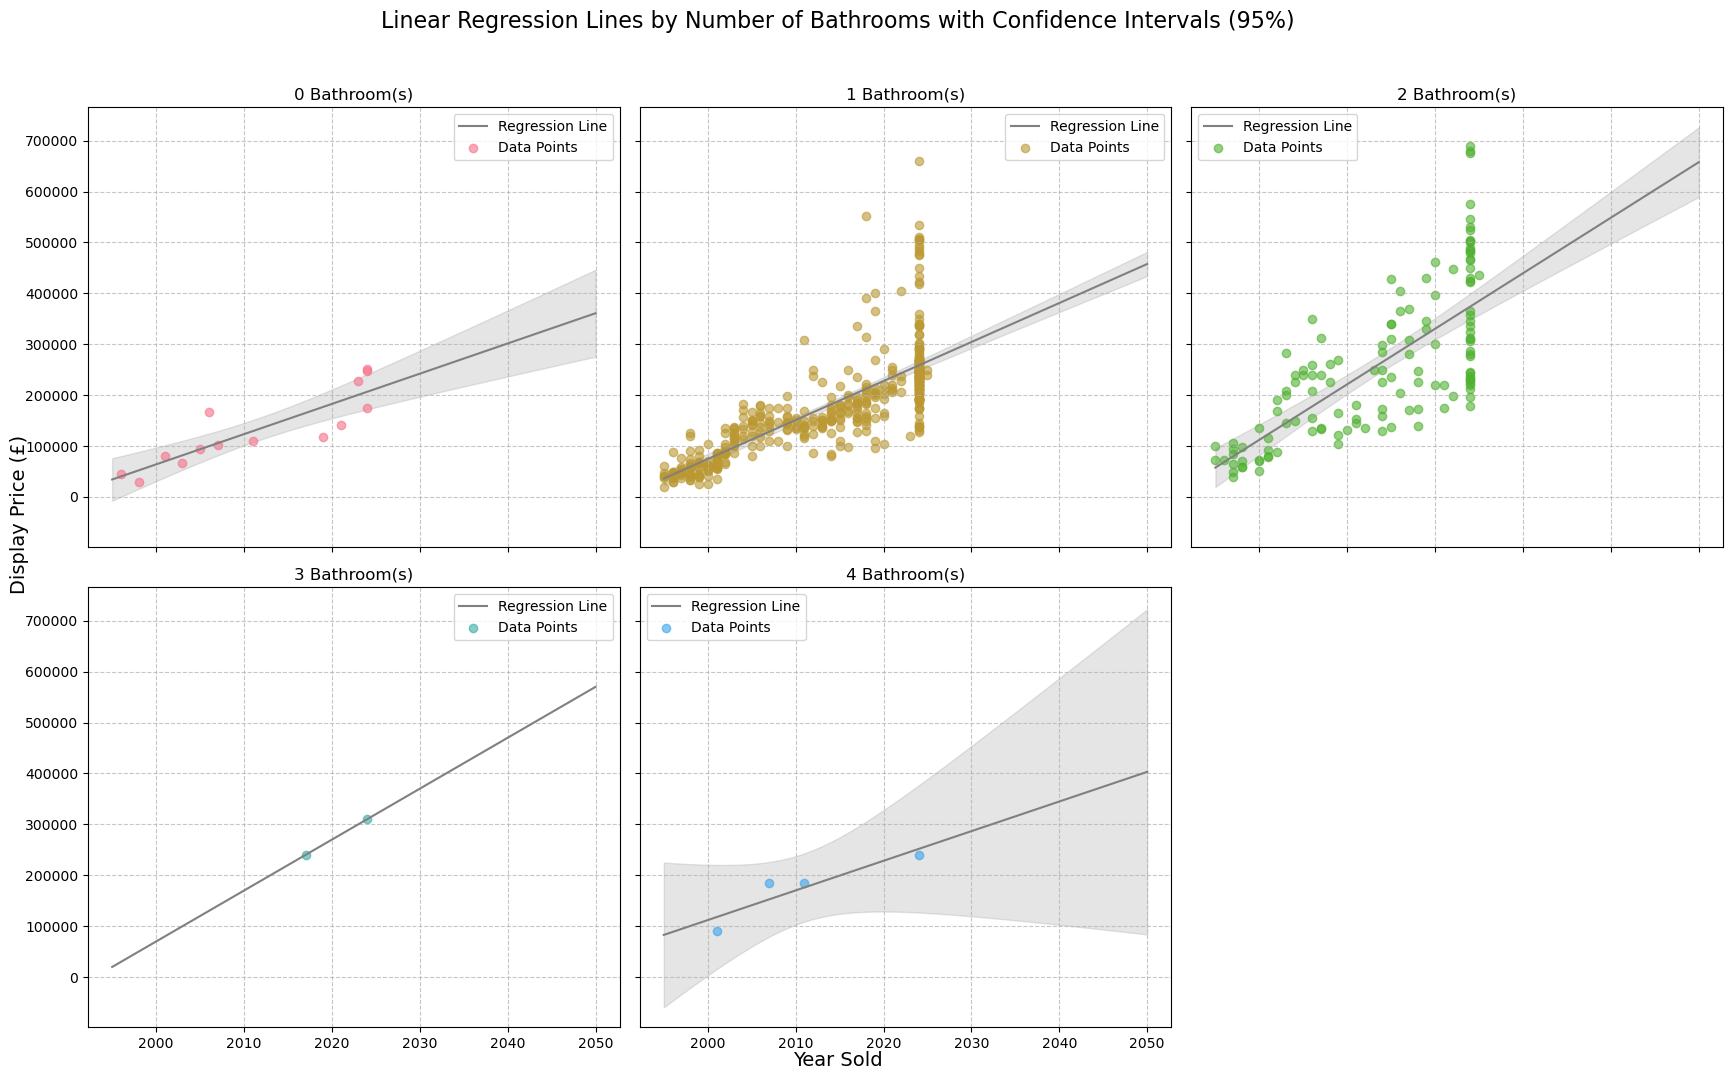

In [32]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(df['bathrooms'].unique()) / 3)), ncols=3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

x_range = np.linspace(df['year_sold'].min(), 2050, 100)

# Loop through each bathroom count and plot its regression line with confidence intervals
for i, bathrooms in enumerate(sorted(df['bathrooms'].unique())):
    ax = axes[i]
    
    # Filter data for the current number of bathrooms
    subset = df[df['bathrooms'] == bathrooms]
    
    # Fit the regression model using statsmodels
    X = sm.add_constant(subset['year_sold'])  # Add constant for the intercept
    y = subset['display_price']
    model = sm.OLS(y, X).fit()
    
    # Predict values and confidence intervals
    X_pred = sm.add_constant(x_range)  # Add constant to the x_range for predictions
    y_pred = model.predict(X_pred)  # Predicted values
    conf_int = model.get_prediction(X_pred).conf_int()  # Confidence intervals
    
    # Plot the regression line
    ax.plot(x_range, y_pred, label='Regression Line', color='gray')
    
    # Plot the confidence intervals as a shaded region
    ax.fill_between(x_range, conf_int[:, 0], conf_int[:, 1], alpha=0.2, color='gray')
    
    # Scatter plot of the data points
    ax.scatter(subset['year_sold'], subset['display_price'], alpha=0.6, label='Data Points', color=colors[i % len(colors)])
    
    # Add title and legend
    ax.set_title(f"{int(bathrooms)} Bathroom(s)")
    ax.legend(fontsize=10)
    ax.grid(linestyle='--', alpha=0.7)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add shared labels and title
fig.suptitle("Linear Regression Lines by Number of Bathrooms with Confidence Intervals (95%)", y=0.92, fontsize=16)
fig.text(0.5, 0.04, "Year Sold", ha="center", fontsize=14)
fig.text(0.04, 0.5, "Display Price (£)", va="center", rotation="vertical", fontsize=14)

plt.tight_layout(rect=[0.04, 0.04, 1, 0.9])
plt.show()

## 1.5 Housing Type

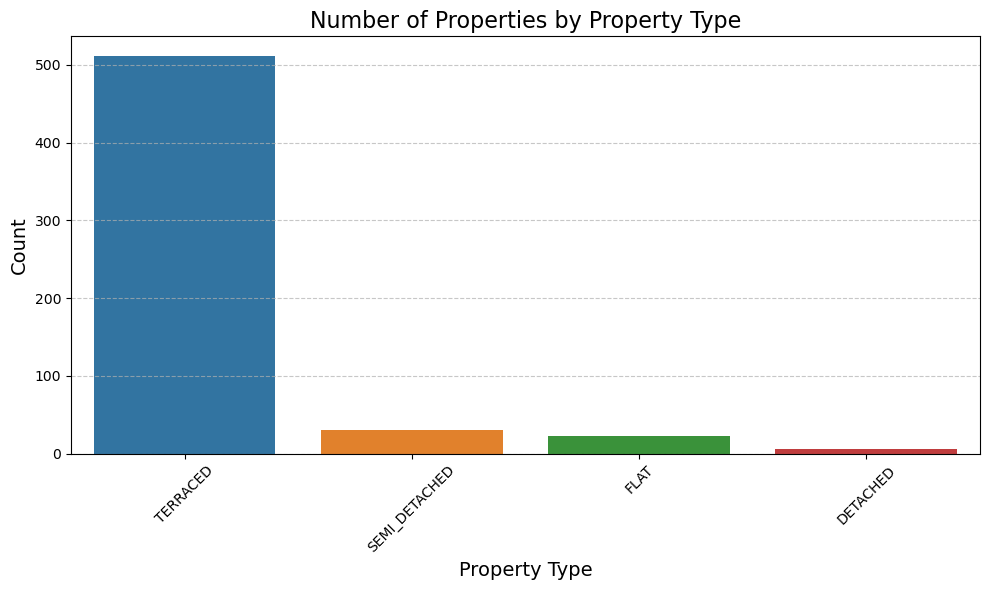

In [13]:
property_type_counts = df['propertyType'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=property_type_counts.index, y=property_type_counts.values, hue=property_type_counts.index, legend=False)
plt.title("Number of Properties by Property Type", fontsize=16)
plt.xlabel("Property Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

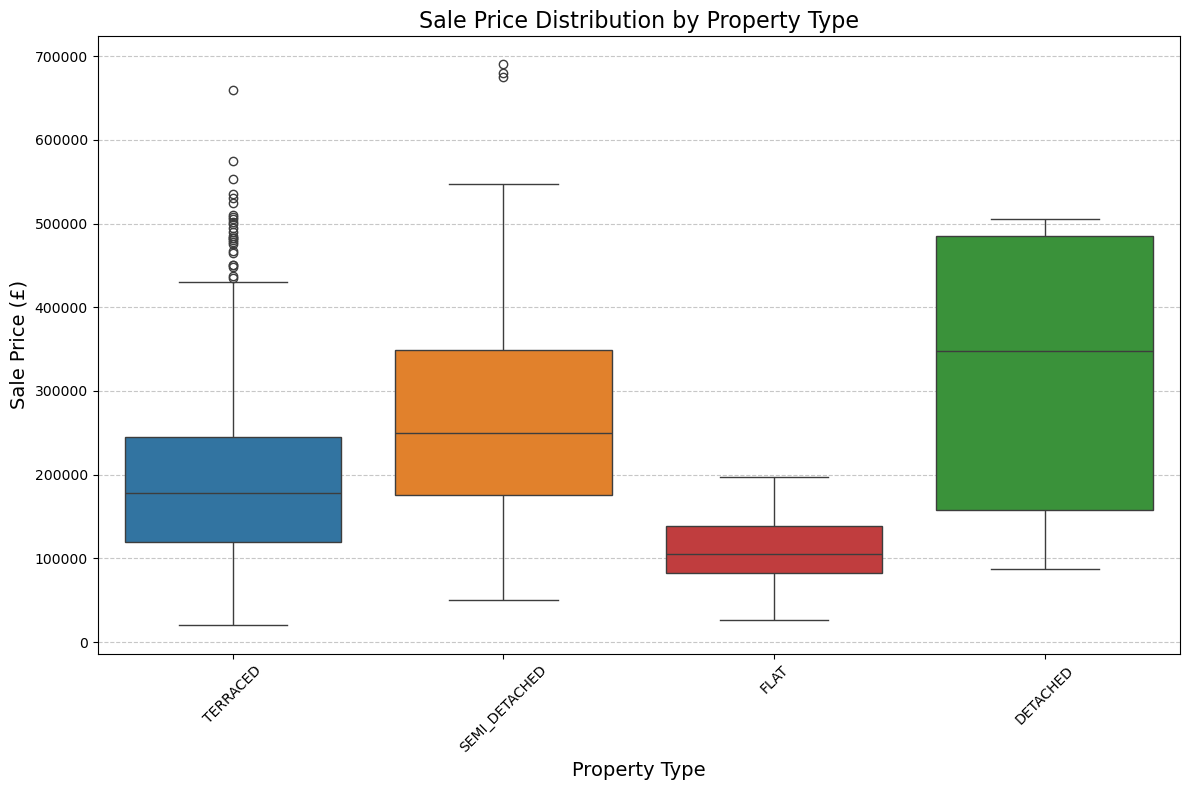

In [18]:
property_type_order = property_type_counts.index

plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='propertyType', y='display_price', hue=df['propertyType'], legend=False, order=property_type_order)

plt.title("Sale Price Distribution by Property Type", fontsize=16)
plt.xlabel("Property Type", fontsize=14)
plt.ylabel("Sale Price (£)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Forecasting

In [23]:
propType_label_encoder = LabelEncoder()
encoded_df = df.copy()
encoded_df['propertyType'] = propType_label_encoder.fit_transform(encoded_df['propertyType'])  # Encode property type as labels
encoded_df.set_index('address')

,propertyType,bedrooms,bathrooms,latitude,longitude,display_price,date_sold,year_sold
address,,,,,,,,
"9, Stallcourt Avenue, Cardiff CF23 5AL",3,3.0,2.0,51.49517,-3.15421,437000.0,20250110,2025
"9, Stallcourt Avenue, Cardiff CF23 5AL",3,3.0,2.0,51.49517,-3.15421,330000.0,20190418,2019
"87, Clifton Street, Cardiff CF24 1LT",3,3.0,1.0,51.48374,-3.15580,240000.0,20250110,2025
"87, Clifton Street, Cardiff CF24 1LT",3,3.0,1.0,51.48374,-3.15580,207000.0,20221028,2022
"87, Clifton Street, Cardiff CF24 1LT",3,3.0,1.0,51.48374,-3.15580,151000.0,20150723,2015
...,...,...,...,...,...,...,...,...
"43, Inverness Place, Cardiff CF24 4RU",3,2.0,1.0,51.49356,-3.17160,217000.0,20240315,2024
"43, Inverness Place, Cardiff CF24 4RU",3,2.0,1.0,51.49356,-3.17160,206000.0,20190830,2019
"43, Inverness Place, Cardiff CF24 4RU",3,2.0,1.0,51.49356,-3.17160,159950.0,20061201,2006


In [125]:
# Define features (X) and target (y)
X = encoded_df[['date_sold', 'bedrooms', 'propertyType', 'bathrooms']]
y = encoded_df['display_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_frac, random_state=42)

In [129]:
X_test

,date_sold,bedrooms,propertyType,bathrooms
507,19991215,2.0,3,1.0
70,20020228,3.0,3,1.0
131,20150119,2.0,3,1.0
400,20110727,2.0,3,1.0
541,20010928,3.0,3,1.0
...,...,...,...,...
199,20190510,3.0,3,1.0
75,20241111,4.0,3,2.0
249,20111118,4.0,3,1.0
421,19981002,3.0,3,1.0


## 2.1 Linear Regression
Okay, I know I already did the Linear Regression above. But let's do it proper as an ML model rather than just fitting it to the entire set.

In [126]:
# Train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred_lr)
print("R Squared:", r2)
mse = mean_squared_error(y_test, y_pred_lr)
print("Mean Squared Error:", mse)

R Squared: 0.7288448049154855
Mean Squared Error: 3757783484.0612874


## 2.2 Decision Tree

In [52]:
# Train a random forest regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred_rf)
print("R Squared:", r2)
mse = mean_squared_error(y_test, y_pred_rf)
print("Mean Squared Error:", mse)

R Squared: 0.6917651856288916
Mean Squared Error: 4271648545.3853526


## 2.3 Gradient Boosting

In [53]:
# Train an XGBoost regressor
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred_xgb)
print("R Squared:", r2)
mse = mean_squared_error(y_test, y_pred_xgb)
print("Mean Squared Error:", mse)

R Squared: 0.6908760256283408
Mean Squared Error: 4283970901.089128


## 2.4 ARIMA and Holt Smoothing

In [123]:
# Aggregate display_price by year_sold
time_series_data = encoded_df.groupby('year_sold')['display_price'].mean()
# Split the time series data into training and testing sets
train_size = int(len(time_series_data) * train_frac)  # 80% training, 20% testing
train_data = time_series_data[:train_size]
test_data = time_series_data[train_size:]

# Holt
hw_model = ExponentialSmoothing(train_data, trend='add', seasonal=None)
hw_model_fit = hw_model.fit()
hw_forecast = hw_model_fit.forecast(steps=len(test_data))
hw_mse = mean_squared_error(test_data, hw_forecast)
hw_r2 = r2_score(test_data, hw_forecast)

# Arima
arima_model = ARIMA(train_data, order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.forecast(steps=len(test_data))
arima_mse = mean_squared_error(test_data, arima_forecast)
arima_r2 = r2_score(test_data, arima_forecast)
                 

# Print the scores
print(f"Holt-Winters MSE: {hw_mse:.2f}, R²: {hw_r2:.2f}")
print(f"ARIMA MSE: {arima_mse:.2f}, R²: {arima_r2:.2f}")

Holt-Winters MSE: 1765244023.74, R²: 0.12
ARIMA MSE: 1752402005.73, R²: 0.12


c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\base\tsa_model.p

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



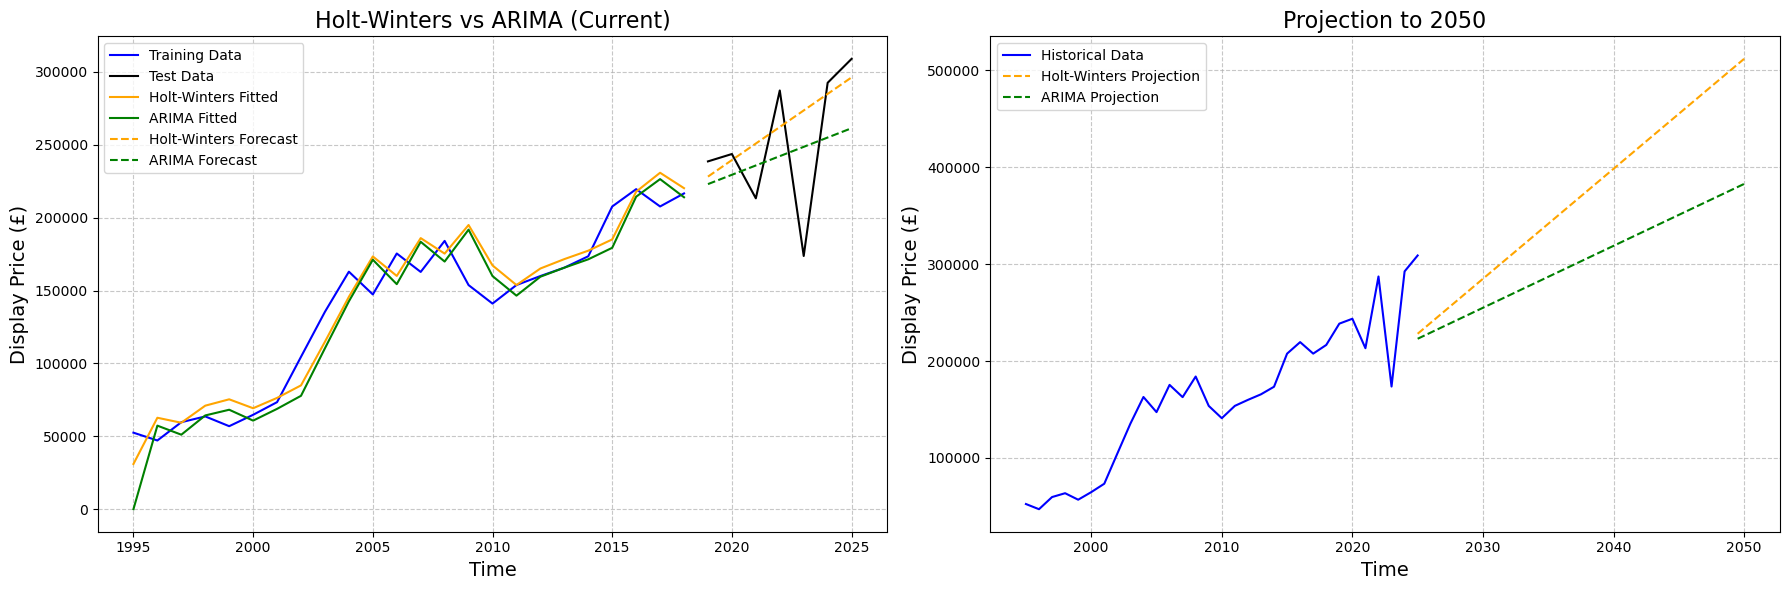

In [124]:
# Extend the forecast to year_max
projection_steps = year_max - 2025 + 1  # Number of years to project from 2025 to year_max
projection_x = np.arange(2025, year_max+1)
# Forecast using Holt-Winters for projection
hw_projection = hw_model_fit.forecast(steps=projection_steps)

# Forecast using ARIMA for projection
arima_projection = arima_model_fit.forecast(steps=projection_steps)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Left Subplot: Current plot (training, test, fitted, and forecast)
ax = axes[0]
ax.plot(train_data, label='Training Data', color='blue')
ax.plot(test_data, label='Test Data', color='black')
ax.plot(train_data.index, hw_model_fit.fittedvalues, label='Holt-Winters Fitted', color='orange', linestyle='-')
ax.plot(train_data.index, arima_model_fit.fittedvalues, label='ARIMA Fitted', color='green', linestyle='-')
ax.plot(test_data.index, hw_forecast, label='Holt-Winters Forecast', color='orange', linestyle='--')
ax.plot(test_data.index, arima_forecast, label='ARIMA Forecast', color='green', linestyle='--')
ax.set_title("Holt-Winters vs ARIMA (Current)", fontsize=16)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Display Price (£)", fontsize=14)
ax.legend(fontsize=10)
ax.grid(linestyle='--', alpha=0.7)

# Right Subplot: Projection to year_max
ax = axes[1]
ax.plot(time_series_data, label='Historical Data', color='blue')
ax.plot(projection_x, hw_projection, label='Holt-Winters Projection', color='orange', linestyle='--')
ax.plot(projection_x, arima_projection, label='ARIMA Projection', color='green', linestyle='--')
ax.set_title(f"Projection to {year_max}", fontsize=16)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Display Price (£)", fontsize=14)
ax.legend(fontsize=10)
ax.grid(linestyle='--', alpha=0.7)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## 2.5 Neural Network

In [ ]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Reshape to match output
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 50
batch_size = 32
train_size = X_train_tensor.size(0)

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(train_size)  # Shuffle the data
    epoch_loss = 0

    for i in range(0, train_size, batch_size):
        indices = permutation[i:i + batch_size]
        batch_X, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / (train_size // batch_size):.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).numpy()

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred_nn)
print("Mean Squared Error:", mse)

Epoch 1/50, Loss: 55765232932.5714
Epoch 2/50, Loss: 56590681526.8571
Epoch 3/50, Loss: 57589007067.4286
Epoch 4/50, Loss: 56320894683.4286
Epoch 5/50, Loss: 55493229714.2857
Epoch 6/50, Loss: 56709167396.5714
Epoch 7/50, Loss: 55414312521.1429
Epoch 8/50, Loss: 58115551817.1429
Epoch 9/50, Loss: 56846372278.8571
Epoch 10/50, Loss: 57304277869.7143
Epoch 11/50, Loss: 58343689947.4286
Epoch 12/50, Loss: 56854381714.2857
Epoch 13/50, Loss: 60644091318.8571
Epoch 14/50, Loss: 58828326473.1429
Epoch 15/50, Loss: 56270134564.5714
Epoch 16/50, Loss: 56951495826.2857
Epoch 17/50, Loss: 55304746569.1429
Epoch 18/50, Loss: 57927855542.8571
Epoch 19/50, Loss: 56864135899.4286
Epoch 20/50, Loss: 55998542994.2857
Epoch 21/50, Loss: 55954736859.4286
Epoch 22/50, Loss: 55299752813.7143
Epoch 23/50, Loss: 58037629220.5714
Epoch 24/50, Loss: 55242919497.1429
Epoch 25/50, Loss: 55396519497.1429
Epoch 26/50, Loss: 55558687305.1429
Epoch 27/50, Loss: 57049967323.4286
Epoch 28/50, Loss: 57317877174.8571
E